Using device: cuda (Mode: DINOSAUR Tuned)
Training...
Step 0: Loss 0.119335
Step 200: Loss 0.066167
Step 400: Loss 0.057491
Step 600: Loss 0.051676
Step 800: Loss 0.052220
Step 1000: Loss 0.045565
Step 1200: Loss 0.042702
Step 1400: Loss 0.041364
Step 1600: Loss 0.041137
Step 1800: Loss 0.038883
Step 2000: Loss 0.038175
Step 2200: Loss 0.038200
Step 2400: Loss 0.036307
Step 2600: Loss 0.035710
Step 2800: Loss 0.033925
Step 3000: Loss 0.033471
Step 3200: Loss 0.033357
Step 3400: Loss 0.034355
Step 3600: Loss 0.033002
Step 3800: Loss 0.032898
Step 4000: Loss 0.032497
Step 4200: Loss 0.032428
Step 4400: Loss 0.032223
Step 4600: Loss 0.030569
Step 4800: Loss 0.030690
Step 5000: Loss 0.030986
Visualizing...


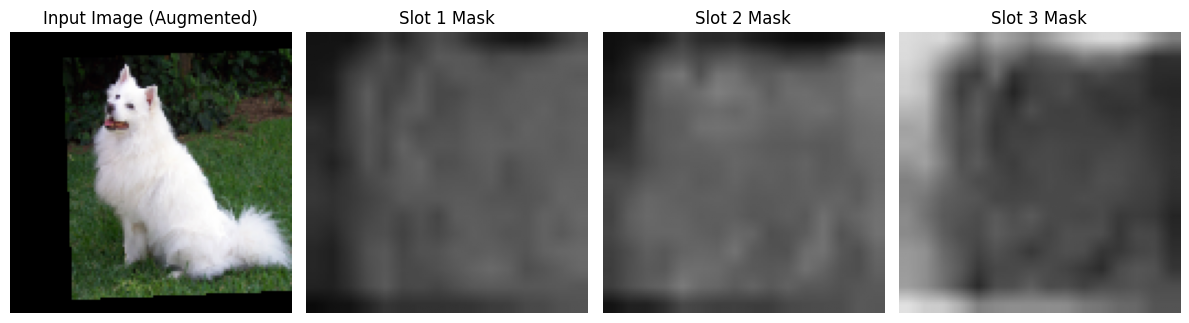

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# ==========================================
# 1. データセット (Augmentation強め)
# ==========================================
class SingleDogDataset(Dataset):
    def __init__(self, resolution=(128, 128), length=50000): 
        self.resolution = resolution
        self.length = length
        self.raw_img = self._load_dog_image()
        
        # Augmentationを少し強めにし、モデルを鍛える
        self.transform = transforms.Compose([
            transforms.RandomAffine(degrees=10, translate=(0.15, 0.15), scale=(0.8, 1.2), fill=0),
            transforms.ToTensor()
        ])

    def _load_dog_image(self):
        url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
        try:
            response = requests.get(url, timeout=5)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            return img.resize(self.resolution)
        except:
            print("Download failed. Using noise.")
            return Image.fromarray(np.uint8(np.random.rand(*self.resolution, 3)*255))

    def __getitem__(self, idx):
        return self.transform(self.raw_img)

    def __len__(self):
        return self.length

# ==========================================
# 2. Feature Extractor (変更なし)
# ==========================================
class FrozenFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1, resnet.layer2
        )
        for param in self.features.parameters():
            param.requires_grad = False
        self.eval()

    def forward(self, x):
        return self.features(x)

# ==========================================
# 3. Slot Attention (LayerNorm追加)
# ==========================================
class SlotAttention(nn.Module):
    def __init__(self, num_slots, dim, iters=3, hidden_dim=128):
        super().__init__()
        self.num_slots = num_slots
        self.iters = iters
        self.scale = dim ** -0.5

        # ★入力特徴量を正規化して、学習を安定させる
        self.norm_features = nn.LayerNorm(dim)

        self.to_q = nn.Linear(dim, dim)
        self.to_k = nn.Linear(dim, dim)
        self.to_v = nn.Linear(dim, dim)
        
        self.gru = nn.GRUCell(dim, dim)
        self.norm_input = nn.LayerNorm(dim)
        self.norm_slots = nn.LayerNorm(dim)
        self.norm_pre_ff = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim), nn.ReLU(inplace=True), nn.Linear(hidden_dim, dim)
        )

    def forward(self, inputs, num_slots=None):
        # inputs: (B, N, D)
        
        # ★ここで入力を正規化！ これが効きます
        inputs = self.norm_features(inputs)

        b, n, d = inputs.shape
        n_s = num_slots if num_slots is not None else self.num_slots
        
        slots = torch.randn(b, n_s, d, device=inputs.device)
        
        k = self.to_k(inputs)
        v = self.to_v(inputs)

        for _ in range(self.iters):
            slots_prev = slots
            slots = self.norm_slots(slots)
            q = self.to_q(slots)
            
            dots = torch.einsum('bid,bjd->bij', q, k) * self.scale
            attn = dots.softmax(dim=1) + 1e-8
            
            attn_sum = attn.sum(dim=-1, keepdim=True)
            updates = torch.einsum('bjd,bij->bid', v, attn / attn_sum)
            slots = self.gru(updates.reshape(-1, d), slots_prev.reshape(-1, d))
            slots = slots.reshape(b, -1, d)
            slots = slots + self.mlp(self.norm_pre_ff(slots))
            
        return slots

# ==========================================
# 4. Model (パラメータ調整済み)
# ==========================================
class DinosaurModel(nn.Module):
    def __init__(self, num_slots=3, slot_dim=128):
        super().__init__()
        self.feature_extractor = FrozenFeatureExtractor()
        
        self.feat_dim = 128
        self.num_slots = num_slots 
        
        # PosEmbの初期値を少し大きくして、位置情報を強調
        self.pos_emb = nn.Parameter(torch.randn(1, 16, 16, self.feat_dim) * 0.05)
        
        self.slot_attention = SlotAttention(num_slots, self.feat_dim, iters=5, hidden_dim=256)
        
        # MLP Decoder (少し層を厚くして表現力アップ)
        self.decoder = nn.Sequential(
            nn.Conv2d(self.feat_dim + 2, 256, 1), nn.ReLU(),
            nn.Conv2d(256, 256, 1), nn.ReLU(),
            nn.Conv2d(256, 256, 1), nn.ReLU(),
            nn.Conv2d(256, self.feat_dim + 1, 1)
        )

    def build_grid(self, batch_size, resolution, device):
        h, w = resolution
        x = torch.linspace(-1, 1, w, device=device)
        y = torch.linspace(-1, 1, h, device=device)
        grid_y, grid_x = torch.meshgrid(y, x, indexing='ij')
        grid = torch.stack((grid_x, grid_y), dim=0).unsqueeze(0).repeat(batch_size, 1, 1, 1)
        return grid

    def forward(self, img):
        with torch.no_grad():
            features = self.feature_extractor(img)
        b, c, h, w = features.shape
        features_perm = features.permute(0, 2, 3, 1)
        features_pos = features_perm + self.pos_emb
        features_flat = features_pos.reshape(b, -1, c)
        
        slots = self.slot_attention(features_flat)
        
        slots_2d = slots.view(b * self.num_slots, self.feat_dim, 1, 1).repeat(1, 1, h, w)
        grid = self.build_grid(b * self.num_slots, (h, w), img.device)
        
        decode_in = torch.cat([slots_2d, grid], dim=1)
        out = self.decoder(decode_in)
        out = out.view(b, self.num_slots, self.feat_dim + 1, h, w)
        
        pred_feats = out[:, :, :self.feat_dim, :, :]
        masks = torch.softmax(out[:, :, self.feat_dim:, :, :], dim=1)
        
        recon_combined = torch.sum(pred_feats * masks, dim=1)
        return recon_combined, features, masks

# ==========================================
# 5. 実行
# ==========================================
def run_final_tuning():
    torch.manual_seed(42) 
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device} (Mode: DINOSAUR Tuned)")

    dataset = SingleDogDataset(length=320000) 
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = DinosaurModel(num_slots=3).to(device)
    # 学習率を少し上げる (0.0004 -> 0.001) MLPは学習が遅いため
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print("Training...")
    model.train()
    
    # しっかり回す
    total_steps = 5000
    
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        optimizer.zero_grad()
        
        recon_feat, target_feat, masks = model(batch)
        loss = ((target_feat - recon_feat)**2).mean()
        loss.backward()
        optimizer.step()
        
        if i % 200 == 0:
            print(f"Step {i}: Loss {loss.item():.6f}")
        
        if i >= total_steps:
            break

    print("Visualizing...")
    model.eval()
    img = dataset[0].unsqueeze(0).to(device)
    
    with torch.no_grad():
        _, _, masks = model(img)

    img_np = img[0].permute(1, 2, 0).cpu().numpy()
    masks = torch.nn.functional.interpolate(masks.view(1*3, 1, 16, 16), size=(128, 128), mode='bilinear')
    masks = masks.view(1, 3, 128, 128)
    masks_np = masks[0].cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1); plt.imshow(img_np); plt.title("Input Image (Augmented)"); plt.axis('off')
    for k in range(3):
        plt.subplot(1, 4, k+2)
        plt.imshow(masks_np[k], cmap='gray', vmin=0, vmax=1)
        plt.title(f"Slot {k+1} Mask")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_final_tuning()